In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import metrics

import tensorflow.keras
from tensorflow.compat.v2.keras.layers import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
tf.compat.v1.disable_eager_execution
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.random.set_seed(368)

In [18]:
xfile = 'C:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'

sequence_size = 360
batch_size = 2048       # Batch size
mini_batch_size = 64       # Batch size

learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 1


y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8


import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web
import h5py
import os

#from keras import backend as K

def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    windows = ds.window(window_size, shift=shift, stride=stride)

    def sub_to_batch(sub, y):
        print (sub)
        print (y)
        s = sub.batch(window_size, drop_remainder=True)
        yy = y.batch(window_size, drop_remainder=True)
        return (s, yy)

    windows = windows.flat_map(sub_to_batch)
    return windows


def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df


df = get_stock_data( ma=[50, 100, 200])
print(df.shape)
amount_of_features = len(df.columns)-1
target = df.pop('y_result')
no_validation_record = (60*24*30)
window_size = 180
window_shift = 1
window_stride = 2
# print ('--start--')
# dataset = tf.compat.v2.data.Dataset.from_tensor_slices((df.values,target.values)).batch(mini_batch_size, drop_remainder=True).batch(batch_size, drop_remainder=True)
# for i in dataset.take(2):
#         print (i)
#         print ('--next--')
# print ('--3--')

# dataset = make_window_dataset(dataset, window_size=sequence_size, shift = 1, stride=1)
# for i in dataset.take(2):
#         print (i)

# print ('--end--')

#validation_dataset = tf.compat.v2.data.Dataset.from_tensor_slices((df.values,target.values)).batch(mini_batch_size, drop_remainder=True).window(batch_size, drop_remainder=True)
#validation_dataset = make_window_dataset(validation_dataset, window_size=sequence_size, shift = 1, stride=1)

#dataset = tf.compat.v2.data.Dataset.from_tensor_slices((df.values,target.values)).range(1, df.shape[0]-no_validation_record).batch(sequence_size, drop_remainder=True).batch(mini_batch_size, drop_remainder=True)
#validation_dataset = tf.compat.v2.data.Dataset.from_tensor_slices((df.values,target.values)).range(df.shape[0]-no_validation_record, df.shape[0]).batch(sequence_size, drop_remainder=True).batch(mini_batch_size, drop_remainder=True)
#tf.compat.v2.data.Dataset.range(30,40).skip(2).take(5).batch(2).window(3,1,1)
dataset = tf.compat.v2.data.Dataset.from_tensor_slices((df.values,target.values)).take(df.shape[0]-no_validation_record).batch(sequence_size, drop_remainder=True).window(mini_batch_size, 1, 1).batch(mini_batch_size)
validation_dataset = tf.compat.v2.data.Dataset.from_tensor_slices((df.values,target.values)).skip(df.shape[0]-no_validation_record).batch(sequence_size, drop_remainder=True).window(mini_batch_size, 1, 1).batch(mini_batch_size)
print(dataset)
print(validation_dataset)

(291141, 8)
<BatchDataset shapes: (DatasetSpec(TensorSpec(shape=(360, 7), dtype=tf.float64, name=None), TensorShape([None])), DatasetSpec(TensorSpec(shape=(360,), dtype=tf.int64, name=None), TensorShape([None]))), types: (DatasetSpec(TensorSpec(shape=(360, 7), dtype=tf.float64, name=None), TensorShape([None])), DatasetSpec(TensorSpec(shape=(360,), dtype=tf.int64, name=None), TensorShape([None])))>
<BatchDataset shapes: (DatasetSpec(TensorSpec(shape=(360, 7), dtype=tf.float64, name=None), TensorShape([None])), DatasetSpec(TensorSpec(shape=(360,), dtype=tf.int64, name=None), TensorShape([None]))), types: (DatasetSpec(TensorSpec(shape=(360, 7), dtype=tf.float64, name=None), TensorShape([None])), DatasetSpec(TensorSpec(shape=(360,), dtype=tf.int64, name=None), TensorShape([None])))>


In [3]:
# %%time
# train_df = pd.read_csv('input/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

In [4]:
# train_df.head()

In [5]:
# X_train = train_df.acoustic_data.values
# y_train = train_df.time_to_failure.values

Find complete segments in the training data (time to failure goes to zero)

In [6]:
# ends_mask = np.less(y_train[:-1], y_train[1:])
# segment_ends = np.nonzero(ends_mask)

# train_segments = []
# start = 0
# for end in segment_ends[0]:
#     train_segments.append((start, end))
#     start = end
    
# print(train_segments)

In [7]:
# plt.title('Segment sizes')
# _ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

The generator samples randomly from the segmens without crossing the boundaries

In [8]:
# class EarthQuakeRandom(keras.utils.Sequence):

#     def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
#         self.x = x
#         self.y = y
#         self.segments = segments
#         self.ts_length = ts_length
#         self.batch_size = batch_size
#         self.steps_per_epoch = steps_per_epoch
#         self.segments_size = np.array([s[1] - s[0] for s in segments])
#         self.segments_p = self.segments_size / self.segments_size.sum()
#         self.x_mean = x_mean
#         self.x_std = x_std

#     def get_batch_size(self):
#         return self.batch_size

#     def get_ts_length(self):
#         return self.ts_length

#     def get_segments(self):
#         return self.segments

#     def get_segments_p(self):
#         return self.segments_p

#     def get_segments_size(self):
#         return self.segments_size

#     def __len__(self):
#         return self.steps_per_epoch

#     def __getitem__(self, idx):
#         segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
#         segment = self.segments[segment_index]
#         end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

#         x_batch = np.empty((self.batch_size, self.ts_length))
#         y_batch = np.empty(self.batch_size, )

#         for i, end in enumerate(end_indexes):
#             x_batch[i, :] = self.x[end - self.ts_length: end]
#             y_batch[i] = self.y[end - 1]
            
#         #x_batch = (x_batch - self.x_mean)/self.x_std
#         return np.expand_dims(x_batch, axis=2), y_batch

We could use any segments for training / validation

In [9]:
# t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
# v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [10]:
# x_sum = 0.
# count = 0

# for s in t_segments:
#     x_sum += X_train[s[0]:s[1]].sum()
#     count += (s[1] - s[0])

# X_train_mean = x_sum/count

# x2_sum = 0.
# for s in t_segments:
#     x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

# X_train_std =  np.sqrt(x2_sum/count)

# print(X_train_mean, X_train_std)

In [11]:
# train_gen = EarthQuakeRandom(
#     x = X_train, 
#     y = y_train,
#     x_mean = X_train_mean, 
#     x_std = X_train_std,
#     segments = t_segments,
#     ts_length = 150000,
#     batch_size = 64,
#     steps_per_epoch = 400
# )

# valid_gen = EarthQuakeRandom(
#     x = X_train, 
#     y = y_train,
#     x_mean = X_train_mean, 
#     x_std = X_train_std,
#     segments = v_segments,
#     ts_length = 150000,
#     batch_size = 64,
#     steps_per_epoch = 400
# )

In [12]:
# print(train_gen)

Use convolutional layers to learn the features and reduce the time sequence length 

In [13]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [14]:
def CnnTransformerModel():
#    i = tf.compat.v2.keras.layers.Flatten(input_shape=(batch_size, amount_of_features))
    i = tf.compat.v2.keras.layers.Input(shape = (sequence_size, amount_of_features), batch_size=mini_batch_size)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 10, strides = 5, activation='relu')(i)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 10, strides = 5, activation='relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 10, strides = 5, activation='relu')(x)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(i)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
 
#    x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
#    max_pool = GlobalMaxPooling1D()(x)
#    concat = concatenate([avg_pool, max_pool])
    y = Dense(1,activation = 'relu')(avg_pool)
    

    return Model(inputs = [i], outputs = [y])

In [15]:
model = CnnTransformerModel()
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(64, 360, 7)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (64, 71, 16)         1136        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (64, 13, 16)         2576        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (64, 1, 16)          2576        conv1d_1[0][0]                   
______________________________________________________________________________________________

**Visualizing The Model Architecture**

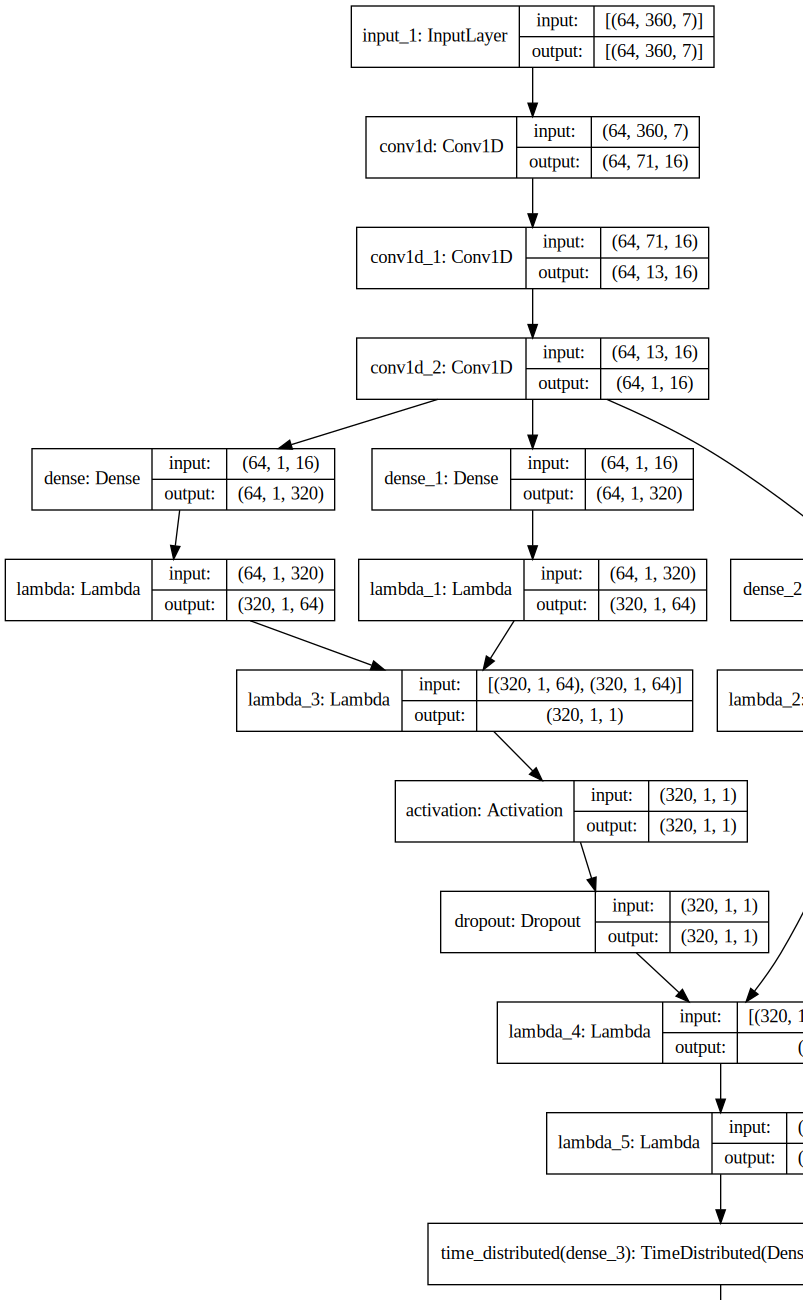

In [16]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [19]:
import time
start_time = time.time()
hist = model.fit_generator(
    generator =  dataset,
    steps_per_epoch = 1,
    epochs = 150, 
    verbose = 1, 
  #  validation_data =  validation_dataset,
  #  validation_steps = 1

)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/150


AttributeError: '_NestedVariant' object has no attribute 'shape'

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Mean Squared Error / Loss')
plt.ylabel('MSE/Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
import gc
del train_gen
del valid_gen
del X_train
del y_train
del train_df
gc.collect()


In [ ]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [ ]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [ ]:
test_data, test_ids = load_test()

In [ ]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>

